# Day 4 lab
## 1. Solving the Knapsack problem using VQE

The knapsack problem is a problem in combinatorial optimization: Given a set of items, each with a weight and a value, determine the number of each item to include in a collection so that the total weight is less than or equal to a given limit and the total value is as large as possible. It derives its name from the problem faced by someone who is constrained by a fixed-size knapsack and must fill it with the most valuable items. The problem often arises in resource allocation where the decision makers have to choose from a set of non-divisible projects or tasks under a fixed budget or time constraint, respectively.

Let's make the needed imports:

In [1]:
# BLOCK 1 - Importing libaries. A lot of new libararies here! 

from qiskit_optimization.applications import Knapsack
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.algorithms import VQE
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import EfficientSU2, TwoLocal
print("All libraries imported successfully!")

All libraries imported successfully!


## Part 1 - Setting up the problem

In [8]:
# BLOCK 2 - Defining the knapsack problem. We define a list of values, a list of weights, the maximum weight, and then
# put it all together into a variable called `problem' using the Knapsack function.
values = [4, 2, 5, 10]   # list of the values of items
weights = [3, 1, 2, 6]   # list of the weights of items
max_weight = 10            # maximum weight capacity (knapsack capacity)

knapsack_problem = Knapsack(values = values, weights = weights, max_weight = max_weight) #putting it all together
qp = knapsack_problem.to_quadratic_program()
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Knapsack

Maximize
 obj: 4 x_0 + 2 x_1 + 5 x_2 + 10 x_3
Subject To
 c0: 3 x_0 + x_1 + 2 x_2 + 6 x_3 <= 10

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1

Binaries
 x_0 x_1 x_2 x_3
End

## Part 2 - Using a classical method to solve the problem

In [3]:
# BLOCK 3- Choosing the method of solving the knapsack problem. Since this is a small problem, we can check the answer we will get later with VQE
# using a classical solver. The method we will use to solve is called `NumPyMinimumEigensolver'.
# We create a variable called method, and store the method we want to use (NumPyMinimumEigensolver) in it
# Later, we will use VQE instead of the classical NumPyMinimumEigensolver.

method = NumPyMinimumEigensolver()

In [4]:
# BLOCK 4 - Using the classical solver NumPyMinimumEigensolver. 
# Run this block to use the classical solver defined in Block 2 to solve the knapsack problem defined in Block 1.
# Can you interpret what these results mean?
calc = MinimumEigenOptimizer(method)
result = calc.solve(knapsack_problem.to_quadratic_program())
print('result:\n', result)
print('\nsolution:\n', knapsack_problem.interpret(result))

result:
 optimal function value: 17.0
optimal value: [0. 1. 1. 1.]
status: SUCCESS

solution:
 [1, 2, 3]


## Part 3 - Using VQE to solve the problem

In [5]:
# BLOCK 5 - Converting the knapsack problem to a quantum circuit, i.e., a colletion of quantum gates (or operators).
# Run this block to convert the knapsack problem to a quantum operator, and print the number of qubits used.
operator, offset = QuadraticProgramToQubo().convert(knapsack_problem.to_quadratic_program()).to_ising()
print("number of qubits =",operator.num_qubits)

number of qubits = 8


In [6]:
# BLOCK 6 - Setting up VQE. We define a QuantumInstance, which is a way of specifying which simulator we want to use.
# We define our tunable circuit for VQE. Here, we will choose EfficientSU2
# We define which classical optimizer we want to use - here we will use one called SPSA
# We tell our code to use VQE with the tunable circuit, the optimizer, and the quantum instance

qinstance = QuantumInstance(backend=Aer.get_backend('qasm_simulator'), shots=1000)

tunable_circuit = EfficientSU2(operator.num_qubits, reps=3, entanglement='full') # QUantum circuit
optimizer = SPSA(maxiter=15) # Classical optimizer

method = VQE(ansatz = tunable_circuit, optimizer = optimizer, quantum_instance = qinstance)

In [7]:
# BLOCK 7 - Running VQE and printing results. This is the same code as in Block 2. 
#The only difference is that here, the method is VQE and not the classical NumPyMinimumEigensolver.
# Did you get the same results as with the classical method?
calc = MinimumEigenOptimizer(method)
result = calc.solve(knapsack_problem.to_quadratic_program())
print('result:\n', result)
print('\nsolution:\n', knapsack_problem.interpret(result))

result:
 optimal function value: 17.0
optimal value: [0. 1. 1. 1.]
status: SUCCESS

solution:
 [1, 2, 3]


# Activity

Try changing the parameters (values, weights, max_weight), and see if VQE still produces the same result as the classical solver.

# Challenge activity

As we discussed in lecture, hybrid algorithms are an active area of research! VQE is not perfect, and can sometimes produce sub-optimal solutions. Can you find a combination of parameters (values, weights, max_weight) that breaks VQE? 

**Hint:** Try making the problem larger! The bigger the problem, the harder it is to find an optimal solution

# 2. Applying the knapsack problem - stock portfolio optimization

## Introduction

Here, we show how to solve a mean-variance portfolio optimization problem for $n$ assets.

Portfolios can be analyzed in a mean-variance framework, with every investor holding the portfolio with the lowest possible return variance consistent with that investor's chosen level of expected return (called a minimum-variance portfolio), if the returns on the assets are jointly elliptically distributed, including the special case in which they are jointly normally distributed. Under mean-variance analysis, it can be shown that every minimum-variance portfolio given a particular expected return (that is, every efficient portfolio) can be formed as a combination of any two efficient portfolios. If the investor's optimal portfolio has an expected return that is between the expected returns on two efficient benchmark portfolios, then that investor's portfolio can be characterized as consisting of positive quantities of the two benchmark portfolios.

In [9]:
# Importing libraries
from qiskit import Aer
from qiskit.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance import QiskitFinanceError
from qiskit_finance.data_providers import WikipediaDataProvider
from qiskit.utils import algorithm_globals
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [10]:
# Helper functions - these functions will help us solve the portfolio optimization problem
# Don't worry about the details of these functions for now - focus on where they are used in the code

# This function imports stock prices using Quandl and Wikipedia. You can edit the start and end datetimes to consider stock prices over a different time period!
# Data is only availble until April 2018, so use time periods earlier than that.
def import_stock_prices(stocks):
    quandl_token = "HRXZqqxBka_9huabBgoW" 
    wiki = WikipediaDataProvider(
                        token = quandl_token,
                        tickers = stocks,
                        start = datetime.datetime(2016,1,1),
                        end = datetime.datetime(2017,1,1))
    wiki.run()
    return wiki

# This function uses matplotlib to plot normalized stock prices
def plot_stock_prices(stock_prices):
    if stock_prices._data:
        for (cnt, s) in enumerate(stocks):
            min_ = np.min(stock_prices._data[cnt])
            max_ = np.max(stock_prices._data[cnt])
            norm = (stock_prices._data[cnt] - min_)/(max_- min_)
            plt.plot(norm, label=s)
        plt.legend()
        plt.title("The normalised yearly evolution of stock prices:")
        plt.xticks(rotation=90)
        plt.show()
    else:
        print('No wiki data loaded.')


## Part 1 - Setting up the problem

## Using real financial data

While the access to real-time data usually requires a payment, it is possible to access historical (adjusted) closing prices via Wikipedia and Quandl free of charge, following registration at: https://www.quandl.com/?modal=register.

We will take $n = 5$ assets for this example. Let's take a look at their stock prices over a period of 1 year in 2017. Can you guess which stocks are represented below?

In [11]:
stocks = [ "AAPL", "NFLX", "AMZN", "IBM", "GOOGL"] # NASDAQ tickers. If you want to consider more stocks, look up their tickers and add them to the list!
# Other stock tickers you can add include F, NVDA, GME, etc. 
stock_prices = import_stock_prices(stocks)  # Using one of the helper functions defined above to import stock prices

### Plot the stock price:

Let's take a look into the underlying stock price. Can you guess which stocks these are?

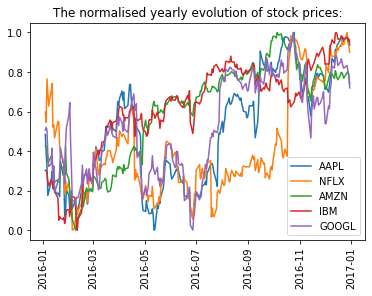

In [12]:
plot_stock_prices(stock_prices) # Using a helper function to plot the stock price

## To the moon!

### Looking at these stock prices, if you had to pick two stocks, which two stocks would you pick?

## Portfolio optimization problem

The mean-variance portfolio optimization problem for $n$ assets is defined as:

$$\min\limits_{x\in\{0,1\}^n}qx^T\Sigma x-\mu^Tx$$

$$\texttt{subject to: }1^Tx=B$$

where:

$x\in\{0,1\}^n$ denotes the vector of binary decision variables, which indicate which assets to pick ($x[i]=1$) and which not to pick ($x[i]=0$),

$\mu\in\mathbb{R}^n$ defines the expected returns for the assets,

$\Sigma\in\mathbb{R}^{n\times n}$ specifies the covariances between the assets,

$q>0$ controls the risk appetite of the decision maker,

$B$ denotes the budget, i.e. the number of assets to be selected out of $n$.

Let's define the important variables in the problem - the number of choices (assets) we have available, and our budget, that is, how many assets we can buy at most.

In [13]:
#num of assets (length of our NASDAQ issues array)
num_assets = len(stocks)

# set budget - how many stocks do you want to buy?
budget = 2

We create the problem to solve with the help of the `PortfolioOptimization` class, just as we had created the Knapsack problem using the Knapsack class

In [15]:
# Defining the portfolio optimization problem
portfolio = PortfolioOptimization(expected_returns=stock_prices.get_period_return_mean_vector(), covariances=stock_prices.get_period_return_covariance_matrix(), risk_factor=0.2, budget=budget)
qp = portfolio.to_quadratic_program() # This creates a quadratic program, which is the form in which the problem can be directly passed to Qiskit's solvers
qp

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: Portfolio optimization

Minimize
 obj: - 0.000573557381 x_0 - 0.000862155433 x_1 - 0.000817863667 x_2
      - 0.001021666721 x_3 - 0.000249093713 x_4 + [ 0.000086798329 x_0^2
      + 0.000103443834 x_0*x_1 + 0.000078108406 x_0*x_2 + 0.000044793255 x_0*x_3
      + 0.000074132146 x_0*x_4 + 0.000313928021 x_1^2 + 0.000152201832 x_1*x_2
      + 0.000047512580 x_1*x_3 + 0.000117537066 x_1*x_4 + 0.000135169298 x_2^2
      + 0.000041726879 x_2*x_3 + 0.000111275075 x_2*x_4 + 0.000061937167 x_3^2
      + 0.000041700932 x_3*x_4 + 0.000063602358 x_4^2 ]/2
Subject To
 c0: x_0 + x_1 + x_2 + x_3 + x_4 = 2

Bounds
 0 <= x_0 <= 1
 0 <= x_1 <= 1
 0 <= x_2 <= 1
 0 <= x_3 <= 1
 0 <= x_4 <= 1

Binaries
 x_0 x_1 x_2 x_3 x_4
End

## Part 2 - Classical Solver: NumPyMinimumEigensolver 

Let's solve the problem using the same classical solver we used above for the knapsack problem. 

**Reading the result of the solver**: The solver will return a list of 0s and 1s as the optimal knapsack. 0 means that the corresponding stock should not be picked for our portfolio, and 1 means that it should be picked. Therefore, an optimal solution of the form \[0 1 1 0 0\] means that we should pick stocks 2 and 3.

In [16]:
exact_mes = NumPyMinimumEigensolver() # Specifying the classical solver we want to use - NumPyMinimumEigensolver
exact_eigensolver = MinimumEigenOptimizer(exact_mes) 

result_classical = exact_eigensolver.solve(qp) # Solving the problem using the classical solver

result_classical # Printing the classical result.

optimal function value: -0.0017201137159862966
optimal value: [0. 0. 1. 1. 0.]
status: SUCCESS

### What was the optimal result? Which two stocks should you have picked? Did the picks match your intuition?

## Part 3 - VQE Solver

Now, let's solve the same problem using VQE. As before, we need to specify a classical optimizer, and we need to specify a quantum circuit. 

### Can you name the calssical optimizer used in the code below?

In [17]:
seed = 123

algorithm_globals.random_seed = 1234
backend = Aer.get_backend('qasm_simulator') # Quantum simulator


quantum_circuit = TwoLocal(num_assets, 'ry', 'cz', reps=3, entanglement='full')  # This is the quantum part of VQE
cobyla = COBYLA()
cobyla.set_options(maxiter=500) # This is the classical optimizer we will use

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

# Now, we will use VQE to solve this problem
vqe_mes = VQE(quantum_circuit, optimizer=cobyla, quantum_instance=quantum_instance) 

vqe = MinimumEigenOptimizer(vqe_mes)
result_vqe = vqe.solve(qp)

result_vqe

optimal function value: -0.0017201137159862966
optimal value: [0. 0. 1. 1. 0.]
status: SUCCESS

### Did VQE get the same result as the classical optimization?